# Inference about effect sizes (IN PROGRESS)
This notebook is going to explore any mistaken research conclusions that may arise from use of the original Rachlin discount function, aand compare that to the Modified Rachlin function.

We will do this in the context of comparing two groups with different discount rates $\kappa$. We will explore a range of true effect sizes (difference in means of 2 groups divided by pooled variance).

Steps are:

1. Define true group means of $\kappa$.
2. Define a range of true effect sizes, varying the variance of $\kappa$ for each group accordingly.
3. Iterate over each true effect size:
    - simulate a dataset of $N$ participants
    - conduct Bayesian inference to estimate effect sizes, doing so for the Rachlin and the Modified Rachlin discount functions.
    - plot the true effect size vs the inferred effect size.
    
**The example below is with differences in group $\kappa$ values, but no group difference in group $s$ values.**

Note that the Bayesian t-test component of this code was inspired by the PyMC3 implementation (here https://github.com/strawlab/best, https://docs.pymc.io/notebooks/BEST.html) of the BEST model by Kruschke (2012).

In [1]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import numpy as np
import math
import pandas as pd

import sys
print(f'Python version:\n{sys.version}\n')

import pymc3 as pm
print(f'PyMC3 v{pm.__version__}')

%run set_plot_options.py
from discount_functions import rachlin, rachlin_kappa
from adaptive_experiment import make_dataset

Python version:
3.6.8 |Anaconda custom (64-bit)| (default, Dec 29 2018, 19:04:46) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]

PyMC3 v3.7


In [2]:
# Initialize random number generator
SEED = 123
np.random.seed(SEED)

# Define sampler options
sample_options = {'tune': 500, 'draws': 1000,
                  'chains': 4, 'cores': 4,
                  'nuts_kwargs': {'target_accept': 0.95},
                  'random_seed': SEED}

Define inference method as `MCMC` or `variational inference`

In [3]:
INFERENCE_METHOD = 'variational inference'

## Functions for simulated dataset generation

In [4]:
def cohend(d1, d2):
    # calculate the size of samples
    n1, n2 = len(d1), len(d2)
    # calculate the variance of the samples
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
    # calculate the pooled standard deviation
    s = math.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # calculate the means of the samples
    u1, u2 = np.mean(d1), np.mean(d2)
    # calculate the effect size
    return (u1 - u2) / s

In [5]:
def make_participant_level_dataset(logκ_std,
                                   groupA_logκmean=-4.6, 
                                   groupB_logκmean=-2.3,
                                   groupA_logsmean=0., 
                                   groupB_logsmean=0.,
                                   logs_std=0.1,
                                   N_per_group=20):
    '''Generate a set of true participant discount function parameter
    values which conforms to the inputs:
    - group means
    - effect size'''
    
    # generate log(κ) values
    a_logκ = np.random.normal(loc=groupA_logκmean, scale=logκ_std, size=N_per_group)
    b_logκ = np.random.normal(loc=groupB_logκmean, scale=logκ_std, size=N_per_group)
    
    # generate log(s) values
    a_logs = np.random.normal(loc=groupA_logsmean, scale=logs_std, size=N_per_group)
    b_logs = np.random.normal(loc=groupB_logsmean, scale=logs_std, size=N_per_group)
    
    dataset = pd.DataFrame()
    dataset['logkappa'] = np.concatenate([a_logκ, b_logκ])
    dataset['logs'] = np.concatenate([a_logs, b_logs])
    dataset['group'] = np.concatenate( (np.zeros(N_per_group), np.ones(N_per_group)))
    # convert to int
    dataset['group'] = np.int_(dataset['group'])
    
    true_logκ_effect_size = cohend(a_logκ, b_logκ)
    true_logs_effect_size = cohend(a_logs, b_logs)
    
    return dataset, true_logκ_effect_size, true_logs_effect_size

In [6]:
def split_apply_combine(df, func):
    '''Ben's useful split-apply-combine utility function.
    We split by row, iterate over them applying the function, then combine into a
    single dataframe.'''
    output = []
    for i in range(df.shape[0]):
        # split by row
        row = df.iloc[i,:]
        # apply function
        output.append(func(row, i))
        
    # combine
    output = pd.concat(output, ignore_index=True)
    return output


def simulate_one_experiment(row, i):
    
    data_generating_discount_func = rachlin_kappa
    
    # extract info from row (HERE IS WHERE WE CONVERT PARAMETERS FROM LOG TO LINEAR SPACE)
    data_generating_params = np.exp(row.logs), np.exp(row.logkappa)
    
    # apply my function... simulate a dataset
    pdata = make_dataset(data_generating_discount_func, data_generating_params)
    
    # add participant number column
    pdata['id'] = pd.Series(i, index=pdata.index)
    
    # add group column
    group = row.group
    pdata['group'] = np.int_(pd.Series(group, index=pdata.index))
    
    return pdata

In [7]:
def simulate_entire_experiment(participant_level_dataset):
    '''Simulate an entire experiment based on the provided true participant level
    parameters.'''
    trial_level_dataset = split_apply_combine(participant_level_dataset, simulate_one_experiment)
    return trial_level_dataset

## Functions for Bayesian inference on effect size

In [8]:
def modified_rachlin(delay, k, s):
    ''' This is the MODIFIED Rachlin discount function.'''
    return 1 / (1.0+(k*delay)**s)


def rachlin(delay, k, s):
    ''' This is the original Rachlin discount function.'''
    return 1 / (1.0+k*delay**s)


def Φ(VA, VB, ϵ=0.01):
    '''Psychometric function which converts the decision variable (VB-VA)
    into a reponse probability. Output corresponds to probability of choosing
    the delayed reward (option B).'''
    return ϵ + (1.0-2.0*ϵ) * (1/(1+pm.math.exp(-1.7*(VB-VA))))

# TODO: Update the Φ function

In [9]:
def participant_group_lookup(trial_level_dataset):
    # create a group lookup table. 1 entry for each particpant
    temp = np.array([trial_level_dataset['id'].values, trial_level_dataset['group'].values]).T
    temp = np.unique(temp, axis=0)
    group = temp[:,1]
    return group

In [10]:
def make_modified_rachlin_model(trial_level_dataset):
    '''Returns a PyMC3 model which does inference on discounting parameters from participants
    from two groups. We have hierachical inference at the group level and we are essentially doing
    a Bayesian t-test where we estimate Cohen's D effect size'''
    
    # extract data from DataFrame
    DA = trial_level_dataset.DA.values
    RA = trial_level_dataset.RA.values
    DB = trial_level_dataset.DB.values
    RB = trial_level_dataset.RB.values
    R = trial_level_dataset.R.values
    id = trial_level_dataset.id.values
    
    group = participant_group_lookup(trial_level_dataset)
    
    n_participants = np.max(trial_level_dataset.id) + 1
    n_groups = 2
     
#     # use actual mean and std as parameters for the prior
#     μ_m = y.value.mean()
#     μ_s = y.value.std() * 2

    σ_low = 0
    σ_high = 10
    
    # Start building the model from the top down, starting with Bayesian t-test
    with pm.Model() as model:
        logκ_group_means = pm.Normal('logκ_group_means', mu=[-4, -2], sd=1, shape=n_groups)
        logκ_group_stds = pm.Uniform('logκ_group_stds', lower=σ_low, upper=σ_high, shape=n_groups)
        # group_logk = pm.Normal('group_logk', mu=group_means, sd=group_stds, shape=n_groups)

        logs_group_means = pm.Normal('logs_group_means', mu=1, sd=1, shape=n_groups)
        logs_group_stds = pm.Uniform('logs_group_stds', lower=σ_low, upper=σ_high, shape=n_groups)
            
    # compute measures about the group level estimates of logk
    with model:
        logκ_diff_of_means = pm.Deterministic('logκ difference of means', logκ_group_means[0] - logκ_group_means[1])
        logκ_diff_of_stds = pm.Deterministic('logκ difference of stds', logκ_group_stds[0] - logκ_group_stds[1])
        logκ_effect_size = pm.Deterministic('logκ effect size',
                                       logκ_diff_of_means / np.sqrt((logκ_group_stds[0]**2 + logκ_group_stds[1]**2) / 2))
        
        logs_diff_of_means = pm.Deterministic('logs difference of means', logs_group_means[0] - logs_group_means[1])
        logs_diff_of_stds = pm.Deterministic('logs difference of stds', logs_group_stds[0] - logs_group_stds[1])
        logs_effect_size = pm.Deterministic('logs effect size',
                                       logs_diff_of_means / np.sqrt((logs_group_stds[0]**2 + logs_group_stds[1]**2) / 2))
        
    # Discounting part of the model
    with model:
        # priors over parameters for each participant
        logκ = pm.Normal('logκ', mu=logκ_group_means[group], sd=logκ_group_stds[group], shape=n_participants)
        logs = pm.Normal('logs', mu=logs_group_means[group], sd=logs_group_stds[group], shape=n_participants)
    
        VA = RA * modified_rachlin(DA, pm.math.exp(logκ[id]), pm.math.exp(logs[id]))  
        VB = RB * modified_rachlin(DB, pm.math.exp(logκ[id]), pm.math.exp(logs[id]))  

        P = pm.Deterministic('P', Φ(VA, VB))

        # Likelihood of observations
        R = pm.Bernoulli('R', p=P, observed=R)

    return model

# High level code here

In [16]:
def infer_effect_size_modified_rachlin(trial_level_dataset, debug=False):
    
    # Build model
    model = make_modified_rachlin_model(trial_level_dataset)
    
    if debug:
        pm.model_to_graphviz(model)
    
    # Do the inference
    if INFERENCE_METHOD == 'variational inference':
        with model:
            advi_fit = pm.fit(method=pm.ADVI(), n=100_000)
            
            advi_elbo = pd.DataFrame({'log-ELBO': -np.log(advi_fit.hist),
                          'n': np.arange(advi_fit.hist.shape[0])})
            plt.plot(advi_elbo['n'], advi_elbo['log-ELBO'])

            trace = advi_fit.sample(10_000)
    
    elif INFERENCE_METHOD == 'MCMC':
        with model:
            trace = pm.sample(**sample_options)
        
    # Calculate summary statistics
    logκ = pm.stats.quantiles(trace['logκ effect size'])
    logs = pm.stats.quantiles(trace['logs effect size'])
    
    # package results into a single row of a DataFrame
    return pd.DataFrame.from_dict({'logκ50': [logκ[50]], 'logκ2.5': [logκ[2.5]], 'logκ97.5': [logκ[97.5]],
                                   'logs50': [logs[50]], 'logs2.5': [logs[2.5]], 'logs97.5': [logs[97.5]]})

Iterate over κstd

Average Loss = 1,411.5: 100%|██████████| 100000/100000 [01:58<00:00, 841.18it/s]
Finished [100%]: Average Loss = 1,411.5
Average Loss = 1,415.1: 100%|██████████| 100000/100000 [01:59<00:00, 839.09it/s]
Finished [100%]: Average Loss = 1,415.1
Average Loss = 1,400.8: 100%|██████████| 100000/100000 [01:51<00:00, 899.68it/s]
Finished [100%]: Average Loss = 1,400.8
Average Loss = 2,526.1:  39%|███▉      | 39432/100000 [00:44<01:04, 934.33it/s]


FloatingPointError: NaN occurred in optimization. 
The current approximation of RV `logκ`.ravel()[31] is NaN.
The current approximation of RV `logs_group_stds_interval__`.ravel()[1] is NaN.
The current approximation of RV `logs_group_means`.ravel()[1] is NaN.
The current approximation of RV `logκ_group_stds_interval__`.ravel()[1] is NaN.
The current approximation of RV `logs`.ravel()[31] is NaN.
The current approximation of RV `logκ_group_means`.ravel()[1] is NaN.
Try tracking this parameter: http://docs.pymc.io/notebooks/variational_api_quickstart.html#Tracking-parameters

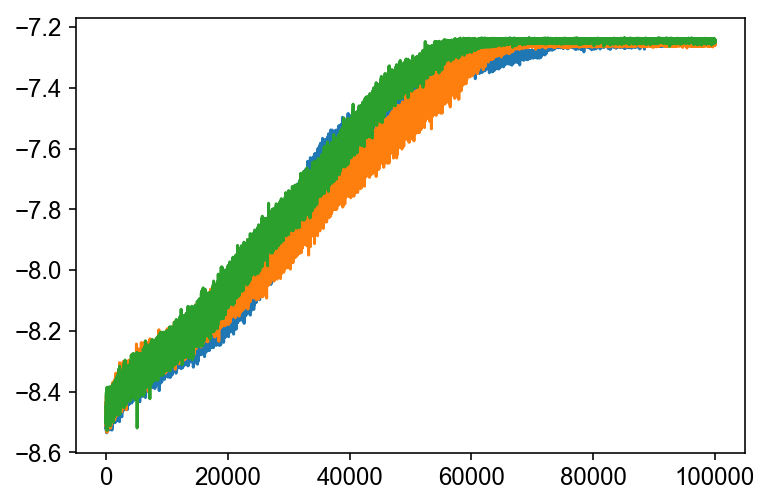

In [17]:
# NOTE: low std means high effect size
group_κstd_list = np.linspace(0.5, 2, 6)

results = []

for group_logκstd in group_κstd_list:

    # INFER EFFECT SIZES FOR GIVEN SET OF GROUP PARAMETERS

    pdataset, true_logκ_effect_size, true_logs_effect_size = make_participant_level_dataset(group_logκstd,
                                       groupA_logκmean=-2.3, 
                                       groupB_logκmean=-4.6,
                                       groupA_logsmean=0, 
                                       groupB_logsmean=0,
                                       logs_std=0.1,
                                       N_per_group=20)

    trial_level_dataset = simulate_entire_experiment(pdataset)

    these_results = infer_effect_size_modified_rachlin(trial_level_dataset)
    
    these_results['logκstd'] = group_logκstd
    these_results['true_logκ_effect_size'] = true_logκ_effect_size
    these_results['true_logs_effect_size'] = true_logs_effect_size

    results.append(these_results)
    
results = pd.concat(results, ignore_index=True)
results

## Plot results

In [ ]:
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# LOG KAPPA PLOT ------------------------------------------------
ax.errorbar(results['true_logκ_effect_size'],
               results['logκ50'], 
               yerr=[results['logκ2.5']-results['logκ50'],
                     results['logκ50']-results['logκ97.5']], 
               fmt='-o', 
               label='modified Rachlin')

ax.plot([0, 5], [0, 5], c='k')

ax.legend()

ax.set(xlabel="True effect size, Cohen's D", 
       ylabel="Inferred effect size, Cohen's D", 
       title='log(κ)');

# Test code to do inference for a given effect size

In [ ]:
group_logκstd = 0.01

participant_level_dataset, true_κ_effect_size, true_s_effect_size = make_participant_level_dataset(group_logκstd,
                                   groupA_logκmean=-4.6, 
                                   groupB_logκmean=-2.3,
                                   groupA_logsmean=0, 
                                   groupB_logsmean=0,
                                   logs_std=0.1,
                                   N_per_group=20)

In [ ]:
trial_level_dataset = simulate_entire_experiment(participant_level_dataset)

Function above will replace the code below after it's all good.

In [ ]:
model = make_modified_rachlin_model(trial_level_dataset)

In [ ]:
pm.model_to_graphviz(model)

In [ ]:
# DO THE INFERENCE
with model:
    trace = pm.sample(**sample_options)

In [ ]:
pm.energyplot(trace)

In [ ]:
pm.forestplot(trace, var_names=['logκ'], r_hat=True);

In [ ]:
pm.forestplot(trace, var_names=['logs'], r_hat=True);

In [ ]:
pm.forestplot(trace, var_names=['logκ_group_means', 'logκ_group_stds']);

In [ ]:
pm.forestplot(trace, var_names=['logs_group_means', 'logs_group_stds'], r_hat=True);

In [ ]:
pm.plot_posterior(trace, var_names=['logκ difference of means','logκ difference of stds', 'logκ effect size'],
                  ref_val=0,
                  color='#87ceeb');

In [ ]:
pm.plot_posterior(trace, var_names=['logs difference of means','logs difference of stds', 'logs effect size'],
                  ref_val=0,
                  color='#87ceeb');

In [ ]:
# TODO extract mean and CI for effect size for logk and logs
# wrap that into a function

In [ ]:
logκ_stats = pm.stats.quantiles(trace['logκ effect size'])
logs_stats = pm.stats.quantiles(trace['logs effect size'])

In [ ]:
logs_stats = pm.stats.quantiles(trace['logs effect size'])

# Variational Inference

In [ ]:
group_logκstd = 0.01

participant_level_dataset, true_κ_effect_size, true_s_effect_size = make_participant_level_dataset(group_logκstd,
                                   groupA_logκmean=-4.6, 
                                   groupB_logκmean=-2.3,
                                   groupA_logsmean=0, 
                                   groupB_logsmean=0,
                                   logs_std=0.1,
                                   N_per_group=20)

In [ ]:
trial_level_dataset = simulate_entire_experiment(participant_level_dataset)

In [ ]:
model = make_modified_rachlin_model(trial_level_dataset)

In [ ]:
with model:
    advi_fit = pm.fit(method=pm.ADVI(), n=60000)

In [ ]:
advi_elbo = pd.DataFrame({'log-ELBO': -np.log(advi_fit.hist),
                          'n': np.arange(advi_fit.hist.shape[0])})
plt.plot(advi_elbo['n'], advi_elbo['log-ELBO'])

In [ ]:
advi_trace = advi_fit.sample(10000)
#pm.traceplot(advi_trace)

In [ ]:
pm.plot_posterior(advi_trace, var_names=['logκ effect size', 'logs effect size'],
                  ref_val=0, color='#87ceeb');

# References
- Kruschke, John. (2012) Bayesian estimation supersedes the t test. Journal of Experimental Psychology: General.